cuda
torch.Size([100, 1, 28, 28])
(302, 302, 3)
torch.Size([1, 28, 28])


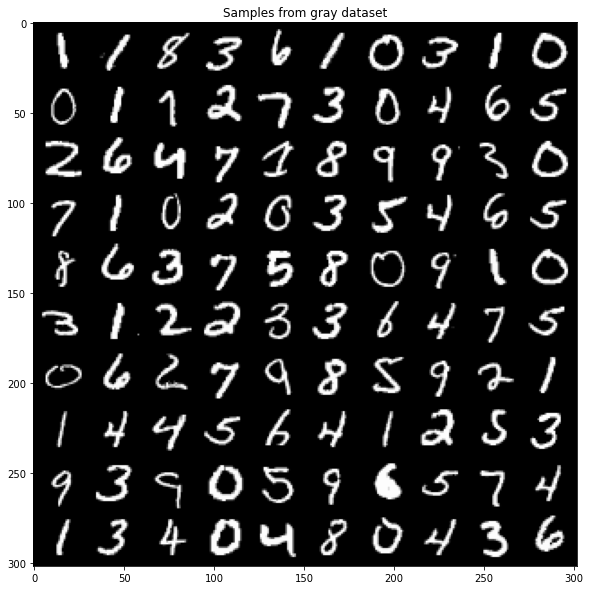

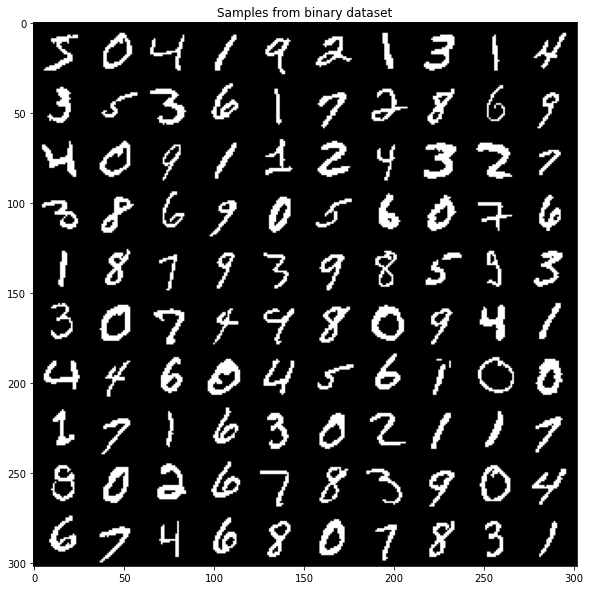

In [38]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from progress.bar import Bar
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import pickle


# %%
writer = SummaryWriter()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


# %%
def to_binary(x):
    zero_mask = x < 0.5
    x[zero_mask] = 0.
    x[~zero_mask] = 1.
    return x

train_dataset_gray = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

test_dataset_gray = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor()
]))

train_dataset_binary = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))

test_dataset_binary = datasets.MNIST('./data', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    to_binary
]))


N_val = 1000
N_train = len(train_dataset_binary) - N_val
N_test = len(test_dataset_binary)


# %%
def make_image_grid(images, nrow=8):
    images = images.float()  # from {0,1,2,3} ints to [0,1] floats
    grid = torchvision.utils.make_grid(images, nrow)
    grid = grid.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    return grid

plt.figure(figsize=(10,10))
plt.title('Samples from gray dataset')
it = iter(train_dataset_gray)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))

print(torch.stack([next(it)[0] for _ in range(100)], dim=0).size())   
plt.imshow(make_image_grid(torch.stack([next(it)[0] for _ in range(100)], dim=0), nrow=10))
del it


# %%
plt.figure(figsize=(10,10))
plt.title('Samples from binary dataset')
it = iter(train_dataset_binary)

imgs = []
labels = []
for i in range(100):
    element = next(it)
    imgs.append(element[0])
    labels.append(element[1])

labels = np.array(labels).reshape((10, 10))

print(make_image_grid(torch.stack(imgs, dim=0), nrow=10).shape)
plt.imshow(make_image_grid(torch.stack(imgs, dim=0), nrow=10))
print(imgs[0].size())
del it


# %%
class LabelToImageNet(nn.Module):
    
    def __init__(self, output_size=28*28):
        super().__init__()
        
        self.hidden_1 = nn.Linear(1, 20)
        self.hidden_2 = nn.Linear(20, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.hidden_4 = nn.Linear(10, 250)
        self.hidden_5 = nn.Linear(250, 500)
        self.hidden_6 = nn.Linear(500, 28*28)
        #self.hidden_3 = nn.Linear(500, 250)
        #self.hidden_4 = nn.Linear(250, 28*28)
        #self.hidden_5 = nn.Linear(*16, 28*28)        
    
    def forward(self, x):
        #x = torch.Tensor([[int(i == z) for i in range(10)] for z in x]).to(device).float()
        x = self.hidden_1(x)
        x =F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        x = F.relu(x)
        x = self.hidden_5(x)
        x = F.relu(x)
        x = self.hidden_6(x)
        #x = F.relu(x)
        x = torch.sigmoid(x)
        return x

def get_sequential_model():
    return nn.Sequential(
        nn.Linear(1, 20),
        nn.ReLU(),
        nn.Linear(20, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 250),
        nn.ReLU(),
        nn.Linear(250, 500),
        nn.ReLU(),
        nn.Linear(500, 28*28),
        nn.Sigmoid()
    )

class VAE(nn.Module):
    def __init__(self, output_size=28*28):
        super().__init__()
        
        self.hidden_1 = nn.Linear(1, 20)
        self.hidden_2 = nn.Linear(20, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.hidden_4 = nn.Linear(10, 250)
        self.hidden_5 = nn.Linear(250, 500)
        self.hidden_6 = nn.Linear(500, 28*28)
        #self.hidden_3 = nn.Linear(500, 250)
        #self.hidden_4 = nn.Linear(250, 28*28)
        #self.hidden_5 = nn.Linear(*16, 28*28)        
    
    def forward(self, x):
        #x = torch.Tensor([[int(i == z) for i in range(10)] for z in x]).to(device).float()
        x = self.hidden_1(x)
        x =F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        x = F.relu(x)
        x = self.hidden_5(x)
        x = F.relu(x)
        x = self.hidden_6(x)
        #x = F.relu(x)
        x = torch.sigmoid(x)
        return x

# %%
lr = 1e-3
reg = 1e-4
batch_size = 512
hidden_size = 64  # h variable in PixelCNN
num_residual_blocks = 12
num_feature_maps = 128  # size of the hidden output layer
batch_norm = True
num_input_channels = 1
num_output_classes = 2
flatten_img_size = 28 * 28


def sample_mnist_pixel_cnn(model, n_classes):
    outputs = []
    for i in range(n_classes):
        print()
        outputs.append(
            torch.reshape(
                model(torch.tensor([i]).to(device).float()),
                (1, 28, 28)
                )
            )
    return torch.stack(outputs, dim=0)


# %%

# alternatively model = torch.nn.Sequential( ?? )
def flatten_processor(output):
    return torch.flatten(output)

def make_float_processor(imgs):
    return imgs.float()


def train(model, train_loader, val_loader, loss, custom_loss=False, mse=False, save_path='./data/test', num_epochs=100):
    train_nll_history = []
    val_nll_history = []
    optimizer = optim.Adam(model.parameters(), lr, weight_decay=reg)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs} ', end='')
        
        model.train()
        for i, minibatch in enumerate(train_loader):
            optimizer.zero_grad()
            labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
            imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

            output = model(labels)
            
            if mse:
                nll = loss(torch.flatten(output), imgs.float())
            else:
                if not custom_loss:
                    outputs = torch.stack(
                        [torch.flatten(1 - output), torch.flatten(output)], dim=1
                    )
                    nll = loss(outputs, imgs.long())

                else:
                    outputs = torch.flatten(output)
                    nll = loss(outputs, imgs)

            nll.backward()
            optimizer.step()
            
            train_nll_history.append(nll.item() / np.log(2.) / 2.)
            
            if i % 50 == 0:
                print('.', end='')
        
        train_loss = np.mean(train_nll_history) / np.log(2.) / 2.
        writer.add_scalar("Loss/train", train_loss, epoch)


        # compute nll on validation set
        val_nlls = []
        model.eval()
        with torch.no_grad():
            for val_minibatch in val_loader:
                val_labels = torch.reshape(minibatch[1].to(device), (-1, 1)).float()
                val_imgs = torch.flatten(torch.reshape(minibatch[0].to(device), (-1, flatten_img_size)))

                output = model(val_labels)
                if mse:
                    val_nll = loss(torch.flatten(output), imgs.float())
                else:
                    if not custom_loss:
                        outputs = torch.stack(
                            [torch.flatten(1 - output), torch.flatten(output)], dim=1
                        )
                        val_nll = loss(outputs, imgs.long())

                    else:
                        outputs = torch.flatten(output)
                        val_nll = loss(outputs, imgs)

            
                val_nlls.append(val_nll.item())
        val_loss = np.mean(val_nlls) / np.log(2.) / 2.

        writer.add_scalar("Loss/val", val_loss, epoch)
        val_nll_history.append(val_loss)
        print("loss: ", val_loss)
        
        samples = sample_mnist_pixel_cnn(model, 10).detach()
        plt.figure(figsize=(6,3))
        img = make_image_grid(samples, nrow=5)
        plt.imsave(os.path.join(save_path, f'epoch_{epoch}.jpg'), img)
        #plt.show()
        

    writer.flush()


def custom_crossentropy(output, target):
    return torch.sum(-target * torch.log(output) - (1 - target) * torch.log(1 - output)) / output.size()[0]


#gray_cross_module_nn
#model = LabelToImageNet().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, custom_crossentropy, custom_loss=True, mse=False, save_path='./data/gray_cross_module_nn', num_epochs=100)



#binary_cross_module_nn
#model = LabelToImageNet().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, nn.CrossEntropyLoss(), mse=False, save_path='./data/binary_cross_module_nn', num_epochs=100)


#binary_cross_sequential
#model = get_sequential_model().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, nn.CrossEntropyLoss(), mse=False, save_path='./data/binary_cross_sequential', num_epochs=100)


#gray_mse_sequential
#model = get_sequential_model().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_gray, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
#train(model, train_loader, val_loader, nn.MSELoss(), mse=True, save_path='./data/gray_mse_sequential', num_epochs=100)


#binary_mse_sequential
#model = get_sequential_model().to(device)
#train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                           sampler=SubsetRandomSampler(list(range(N_train))))
#val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
#                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))

#train(model, train_loader, val_loader, nn.MSELoss(), mse=True, save_path='./data/binary_mse_sequential', num_epochs=100)

class Encoder(nn.Module):
    def __init__(self, latent_space_size):
        super(Encoder, self).__init__()
        self.hidden_1 = nn.Linear(28 * 28, 512)
        self.hidden_2 = nn.Linear(512, 256)
        #self.hidden_3 = nn.Linear(250, 10)
        #self.hidden_4 = nn.Linear(10, 10)
        ##self.hidden_5 = nn.Linear(10, 20)
        #self.hidden_6 = nn.Linear(20, 10)

        self.mean = nn.Linear(256, latent_space_size)
        self.log_std = nn.Linear(256, latent_space_size)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        #x = self.hidden_3(x)
        #x = F.relu(x)
        #x = self.hidden_4(x)
        #x = F.relu(x)
        #x = self.hidden_5(x)
        #x = F.relu(x)
        #x = self.hidden_6(x)
        #x = F.relu(x)

        return self.mean(x), self.log_std(x)


class Decoder(nn.Module):
    def __init__(self, latent_space_size):
        super(Decoder, self).__init__()
        self.hidden_1 = nn.Linear(latent_space_size, 256)
        self.hidden_2 = nn.Linear(256, 512)
        #self.hidden_3 = nn.Linear(512, 10)
        ##self.hidden_4 = nn.Linear(10, 10)
        #self.hidden_5 = nn.Linear(10, 250)
        #self.hidden_6 = nn.Linear(250, 500)
        self.result = nn.Linear(512, 28 * 28)
        # self.mean = nn.Linear(500, 28 * 28)

        # self.log_std = nn.Linear(500, 28 * 28)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        #x = self.hidden_3(x)
        #x = F.relu(x)
        #x = self.hidden_4(x)
        #x = F.relu(x)
        #x = self.hidden_5(x)
        #x = F.relu(x)
        #x = self.hidden_6(x)
        #x = F.relu(x)

        return torch.sigmoid(self.result(x))#, self.log_std(x)


class VAE(nn.Module):
    def __init__(self, n_inputs, latent_space_size):
        super(VAE, self).__init__()
        self.latent_space_size = latent_space_size
        self.encoder = Encoder(latent_space_size)
        self.decoder = Decoder(latent_space_size)
    
    def sample_latent(self, m_z, log_std_z):
        if self.training:
            eps = torch.randn_like(m_z)
            sample = eps * log_std_z.exp() + m_z
            return sample
        else:
            return m_z

    def forward(self, x):
        m_z, log_std_z = self.encoder(x)
        z = self.sample_latent(m_z, log_std_z)
        # mu_x, log_std_x = self.decoder(z)
        reconstruction = self.decoder(z)
        
        #return m_z, log_std_z, mu_x, log_std_x
        return m_z, log_std_z, reconstruction
    
    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_space_size).to(device)
            mu = self.decoder(z)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return torch.reshape(z, (28, 28)).cpu().numpy()


def vae_loss(image, m_z, log_std_z, reconstruction):
    BCE = F.binary_cross_entropy(input=reconstruction.view(-1, 28 * 28), target=image.view(-1, 28 * 28), reduction='sum').sum()

    # loss = 0.5 * ((x - mu_x) ** 2 / torch.exp(2 * log_std_x) + log_std_x + np.log(2 * np.pi)).sum(1).mean()

    KL_divergence = -(0.5 * (1 + log_std_z - m_z.pow(2) - torch.exp(2 * log_std_z))).sum(1).sum()

    return (BCE + KL_divergence, BCE, KL_divergence)


def train_VAE(vae, dataloader, epochs=3, verbose=False):
    vae = vae.to(device)
    optimizer = optim.Adam(params=vae.parameters(), lr=1e-4)
    vae.train()

    losses = []
    reconstruction_losses = []
    KL_losses = []
    all_losses = [] 

    final_KL = 0
    final_reconstr = 0

    for epoch in range(epochs):
        losses.append(0)
        n_batches = 0

        for sample in dataloader:
            sample = torch.reshape(sample[0], (-1, 28 * 28)).to(device).float()
            optimizer.zero_grad()
            mu_z, log_std_z, reconstruction = vae(sample)

            (loss, reconstruction_loss, KL_loss) = vae_loss(sample, mu_z, log_std_z, reconstruction)
            loss.backward()

            optimizer.step()
            losses[-1] += loss.item()
            final_KL += KL_loss.item()
            final_reconstr += reconstruction_loss.item()

            reconstruction_losses.append(reconstruction_loss.item())
            KL_losses.append(KL_loss.item())
            all_losses.append(loss.item())

            n_batches += 1

        losses[-1] /= n_batches
        final_KL /= n_batches
        final_reconstr /= n_batches

        if not verbose:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch + 1, epochs, losses[-1]))  
    
    return all_losses, reconstruction_losses, KL_losses, losses[-1], final_reconstr, final_KL

def print_training_results(all_losses, reconstruction_losses, KL_losses, y_lim=(-1, 10), x_lim=(0, 30000)):
    figure(figsize=(8, 6), dpi=80)
    plt.ylim(y_lim[0], y_lim[1])
    plt.xlim(x_lim[0], x_lim[1])


    line_loss = plt.plot(range(len(all_losses)), all_losses, color='palegreen', label='ELBO')
    line_rec = plt.plot(range(len(reconstruction_losses)), reconstruction_losses, color='gold', label='reconstruction_loss')
    line_kl = plt.plot(range(len(KL_losses)), KL_losses, color='mediumorchid', label='KL_loss')
    plt.legend()
    plt.show()


# %%


In [5]:


model = VAE(28 * 28, 2).to(device)
train_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(list(range(N_train))))
val_loader = torch.utils.data.DataLoader(train_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(N_train, N_train + N_val))))
train_VAE(model, train_loader, epochs=10)


Epoch [1 / 10] average reconstruction error: 166739.369797
Epoch [2 / 10] average reconstruction error: 106570.462234
Epoch [3 / 10] average reconstruction error: 100718.367726
Epoch [4 / 10] average reconstruction error: 97472.478785
Epoch [5 / 10] average reconstruction error: 94167.835668
Epoch [6 / 10] average reconstruction error: 90599.702973
Epoch [7 / 10] average reconstruction error: 88795.172313
Epoch [8 / 10] average reconstruction error: 87533.552347
Epoch [9 / 10] average reconstruction error: 86431.173323
Epoch [10 / 10] average reconstruction error: 85558.724492


([279040.9375,
  277929.65625,
  276863.96875,
  275820.84375,
  274787.21875,
  273750.34375,
  272654.5625,
  271720.1875,
  270275.375,
  268833.65625,
  267773.125,
  266606.09375,
  265115.46875,
  263557.59375,
  261928.375,
  260368.46875,
  258715.546875,
  256614.125,
  254581.28125,
  251900.78125,
  249390.109375,
  246554.75,
  245317.796875,
  242234.671875,
  237963.546875,
  236584.03125,
  230014.21875,
  226576.5625,
  222156.765625,
  217954.09375,
  215352.03125,
  209612.953125,
  202284.15625,
  196835.578125,
  195756.859375,
  191278.375,
  190030.9375,
  188395.8125,
  181863.609375,
  176415.796875,
  173876.484375,
  172710.28125,
  168412.328125,
  165792.140625,
  161583.875,
  159420.0625,
  158107.015625,
  154299.734375,
  150536.765625,
  150363.28125,
  144659.671875,
  145143.796875,
  146273.859375,
  143130.53125,
  143734.109375,
  140640.890625,
  138338.375,
  137768.984375,
  138899.96875,
  132947.84375,
  136458.9375,
  132953.171875,
  134118.

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)


def display_latents(vae, val_loader):
    color_mapping = {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'yellow',
        4: 'pink',
        5: 'blueviolet',
        6: 'black',
        7: 'grey',
        8: 'salmon',
        9: 'peru'
    }

    scatter = {color:[[], []] for color in color_mapping.values()}
    bar = Bar('Exporting', max=len(val_loader))

    for sample in val_loader:
        bar.next()
        img = sample[0]
        labels = sample[1].detach().cpu().numpy()
        img = torch.reshape(img, (-1, 28 * 28)).to(device).float()
        
        mu_z, log_std_z = vae.encoder(img)
        z = (torch.randn_like(mu_z) * log_std_z.exp() + mu_z).detach().cpu().numpy()
        for i in range(z.shape[0]):
            plt.scatter([z[i][0]], [z[i][1]], color=color_mapping[labels[i]], s=8)
    bar.finish()

#display_latents(model, val_loader)

<Figure size 640x640 with 0 Axes>

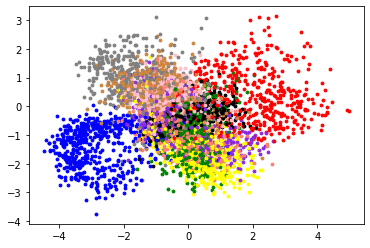

In [8]:
test_loader = torch.utils.data.DataLoader(test_dataset_binary, batch_size=batch_size,
                                         sampler=SubsetRandomSampler(list(range(5000))))
display_latents(model, test_loader)

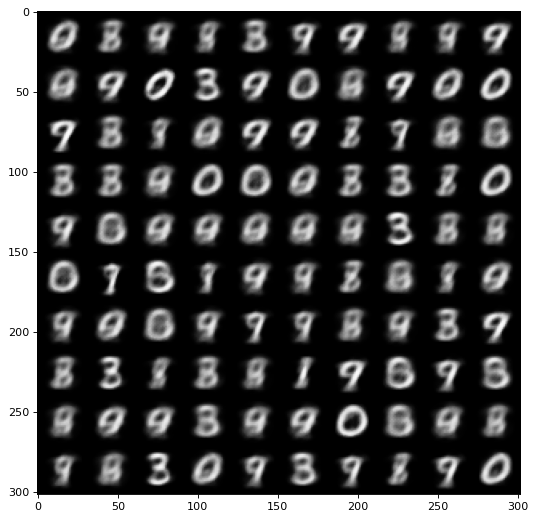

In [54]:
noise = False
n = 100

figure(figsize=(8, 8), dpi=80)

with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    reconstructed = model.decoder(z)
    if noise:
        z = torch.randn_like(mu) * log_std.exp() + mu
    else:
        z = reconstructed
imgs = (torch.reshape(z, (-1, 1, 28, 28)) * 255)

nrows = 10
grid = torchvision.utils.make_grid(imgs, nrows)
grid = grid.detach().cpu().numpy()[1, :, :]  # from CHW to HWC
plt.imshow(1 - grid, cmap='Greys')

In [50]:
imgs = (torch.reshape(z, (-1, 1, 28, 28)) * 255)
grid = torchvision.utils.make_grid(imgs, nrow=2)
grid.shape

torch.Size([3, 152, 62])

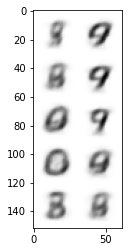

In [51]:
plt.imshow(grid.detach().cpu().numpy()[1, :, :], cmap='Greys')

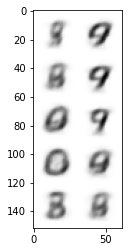

In [52]:
plt.imshow(grid.detach().cpu().numpy()[0, :, :], cmap='Greys')